In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r", "human_VDss_L_kg", "human_CL_mL_min_kg"
                               ,"human_fup", "human_mrt", "human_thalf" ]]
human_inchi = human_lombardo[[ "smiles_r"]]
human_lombardo
for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [5]:
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [6]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  
0               0.638489       0.33   0.568202     1.176091  
1               0.949390        NaN   1.348305     1.705008  
2              -0.537602       0.01   1.482588     1.894870  
3               1.301030       0.13   0.204120     0.113943  
4               0.204120        NaN   1.068186     1.037426  
...                  ...        ...        ...          ...  
1278            0.903090        NaN   1.021189     0.913814  
1279            0.707570       0.35   1.361728     1.204120  
1280            0.934498       0.50   0.892095     0.863323  
1281            1.293804        NaN   0.537819     0.359835  
1282            1.000000        NaN   0.740363     0.623249  

[1283 rows x 6 columns]

In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

def get_pairwise_correlation(population_df, method="pearson"):
    """Given a population dataframe, calculate all pairwise correlations.
    Parameters
    ----------
    population_df : pandas.core.frame.DataFrame
        Includes metadata and observation features.
    method : str, default "pearson"
        Which correlation matrix to use to test cutoff.
    Returns
    -------
    list of str
        Features to exclude from the population_df.
    """


    # Get a symmetrical correlation matrix
    data_cor_df = population_df.corr(method=method)

    # Create a copy of the dataframe to generate upper triangle of zeros
    data_cor_natri_df = data_cor_df.copy()

    # Replace upper triangle in correlation matrix with NaN
    data_cor_natri_df = data_cor_natri_df.where(
        np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)
    )

    # Acquire pairwise correlations in a long format
    # Note that we are using the NaN upper triangle DataFrame
    pairwise_df = data_cor_natri_df.stack().reset_index()
    pairwise_df.columns = ["pair_a", "pair_b", "correlation"]

    return data_cor_df, pairwise_df

def determine_high_cor_pair(correlation_row, sorted_correlation_pairs):
    """
    Select highest correlated variable given a correlation row with columns:
    ["pair_a", "pair_b", "correlation"]
    For use in a pandas.apply()
    """

    pair_a = correlation_row["pair_a"]
    pair_b = correlation_row["pair_b"]

    if sorted_correlation_pairs.get_loc(pair_a) > sorted_correlation_pairs.get_loc(pair_b):
        return pair_a
    
    else:
        return pair_b
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [8]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

smiles_r
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3                             C#CC[NH+](C)C(C)Cc1ccccc1
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...                                                 ...
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2

[1283 rows x 1 columns]

In [9]:
from rdkit import Chem

In [10]:
Ser_Mol = human_lombardo['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']

In [11]:
selected_Features = fs_variance(Morganfingerprint_table.iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Morganfingerprint_table= Morganfingerprint_table[selected_Features]
new_Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']
new_Morganfingerprint_table

152


/tmp/ipykernel_151935/4098812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Morganfingerprint_table['smiles_r'] = human_lombardo['smiles_r']


Mfp1  Mfp13  Mfp80  Mfp90  Mfp114  Mfp116  Mfp117  Mfp118  Mfp119  \
0        1      0      1      0       0       0       1       0       0   
1        0      0      1      0       1       0       0       0       0   
2        1      0      1      0       0       0       1       0       0   
3        1      0      1      0       0       0       0       0       0   
4        0      0      1      0       0       0       0       0       1   
...    ...    ...    ...    ...     ...     ...     ...     ...     ...   
1278     0      0      0      0       0       0       0       0       0   
1279     0      0      0      0       0       0       0       0       0   
1280     0      0      0      0       0       0       0       0       0   
1281     0      0      1      0       0       0       0       0       0   
1282     0      0      0      0       0       0       0       0       0   

      Mfp140  ...  Mfp1917  Mfp1921  Mfp1928  Mfp1970  Mfp1980  Mfp1991  \
0          0  ...        1        0        0        0        0        0   
1          0  ...        1        0        0        0        0        0   
2          0  ...        1        0        1        0        0        1   
3          0  ...        0        0        0        0        0        0   
4          0  ...        0        1        0        0        0        0   
...      ...  ...      ...      ...      ...      ...      ...      ...   
1278       0  ...        0        0        0        0        0        0   
1279       0  ...        0        0        0        0        0        0   
1280       0  ...        0        0        0        0        0        0   
1281       0  ...        0        1        0        0        0        0   
1282       0  ...        0        0        0        0        0        0   

      Mfp2010  Mfp2031  Mfp2038  \
0           0        0        0   
1           0        0        0   
2           0        0        0   
3           0        1        0   
4           0        0        0   
...       ...      ...      ...   
1278        0        0        0   
1279        0        0        0   
1280        0        0        0   
1281        0        0        0   
1282        0        0        0   

                                               smiles_r  
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...  
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1  
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...  
3                             C#CC[NH+](C)C(C)Cc1ccccc1  
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...  
...                                                 ...  
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2  
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1  
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1  
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2  

[1283 rows x 153 columns]

In [12]:
mfp_columns = new_Morganfingerprint_table.columns[:-1].tolist()
#Mordred_columns = Mordred_table.columns[:-1].tolist()
#mfp_columns = Morganfingerprint_table.columns[:-1].tolist()

features_mfp_columns = mfp_columns
print(len(features_mfp_columns))

#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_columns_human.txt", "w")
for item in features_mfp_columns:
   f.write(item + "\n")
f.close()

152


In [13]:
#read from file
file = open("features_mfp_columns_human.txt", "r")
file_lines = file.read()
features_mfp_columns = file_lines.split("\n")
features_mfp_columns = features_mfp_columns[:-1]
features_mfp_columns

['Mfp1',
 'Mfp13',
 'Mfp80',
 'Mfp90',
 'Mfp114',
 'Mfp116',
 'Mfp117',
 'Mfp118',
 'Mfp119',
 'Mfp140',
 'Mfp147',
 'Mfp195',
 'Mfp197',
 'Mfp213',
 'Mfp216',
 'Mfp222',
 'Mfp227',
 'Mfp231',
 'Mfp233',
 'Mfp249',
 'Mfp257',
 'Mfp262',
 'Mfp271',
 'Mfp283',
 'Mfp294',
 'Mfp310',
 'Mfp314',
 'Mfp322',
 'Mfp350',
 'Mfp352',
 'Mfp361',
 'Mfp378',
 'Mfp383',
 'Mfp387',
 'Mfp389',
 'Mfp392',
 'Mfp397',
 'Mfp407',
 'Mfp444',
 'Mfp457',
 'Mfp486',
 'Mfp561',
 'Mfp573',
 'Mfp607',
 'Mfp650',
 'Mfp656',
 'Mfp658',
 'Mfp667',
 'Mfp675',
 'Mfp679',
 'Mfp694',
 'Mfp695',
 'Mfp699',
 'Mfp715',
 'Mfp718',
 'Mfp739',
 'Mfp785',
 'Mfp787',
 'Mfp794',
 'Mfp802',
 'Mfp807',
 'Mfp816',
 'Mfp841',
 'Mfp843',
 'Mfp849',
 'Mfp875',
 'Mfp881',
 'Mfp926',
 'Mfp935',
 'Mfp984',
 'Mfp1017',
 'Mfp1019',
 'Mfp1027',
 'Mfp1028',
 'Mfp1039',
 'Mfp1057',
 'Mfp1060',
 'Mfp1066',
 'Mfp1074',
 'Mfp1088',
 'Mfp1097',
 'Mfp1114',
 'Mfp1126',
 'Mfp1145',
 'Mfp1152',
 'Mfp1154',
 'Mfp1160',
 'Mfp1162',
 'Mfp1171',
 'Mfp11

In [14]:
human_lombardo_mfp = pd.merge(human_lombardo, new_Morganfingerprint_table)
human_lombardo_mfp

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

smiles_r  human_VDss_L_kg  \
0     C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...         0.006466   
1         C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1         1.079181   
2     C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...        -0.275724   
3                             C#CC[NH+](C)C(C)Cc1ccccc1         0.278754   
4     C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...         0.041393   
...                                                 ...              ...   
1278                    c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2         0.556303   
1279                   c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1         0.838849   
1280              c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1         0.612784   
1281                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1         0.591065   
1282                     c1ccc2c(c1)OCC(C1=[NH+]CCN1)O2         0.518514   

      human_CL_mL_min_kg  human_fup  human_mrt  human_thalf  Mfp1  Mfp13  \
0               0.638489       0.33   0.568202     1.176091     1      0   
1               0.949390        NaN   1.348305     1.705008     0      0   
2              -0.537602       0.01   1.482588     1.894870     1      0   
3               1.301030       0.13   0.204120     0.113943     1      0   
4               0.204120        NaN   1.068186     1.037426     0      0   
...                  ...        ...        ...          ...   ...    ...   
1278            0.903090        NaN   1.021189     0.913814     0      0   
1279            0.707570       0.35   1.361728     1.204120     0      0   
1280            0.934498       0.50   0.892095     0.863323     0      0   
1281            1.293804        NaN   0.537819     0.359835     0      0   
1282            1.000000        NaN   0.740363     0.623249     0      0   

      Mfp80  Mfp90  ...  Mfp1915  Mfp1917  Mfp1921  Mfp1928  Mfp1970  Mfp1980  \
0         1      0  ...        0        1        0        0        0        0   
1         1      0  ...        0        1        0        0        0        0   
2         1      0  ...        0        1        0        1        0        0   
3         1      0  ...        0        0        0        0        0        0   
4         1      0  ...        0        0        1        0        0        0   
...     ...    ...  ...      ...      ...      ...      ...      ...      ...   
1278      0      0  ...        0        0        0        0        0        0   
1279      0      0  ...        0        0        0        0        0        0   
1280      0      0  ...        0        0        0        0        0        0   
1281      1      0  ...        0        0        1        0        0        0   
1282      0      0  ...        0        0        0        0        0        0   

      Mfp1991  Mfp2010  Mfp2031  Mfp2038  
0           0        0        0        0  
1           0        0        0        0  
2           1        0        0        0  
3           0        0        1        0  
4           0        0        0        0  
...       ...      ...      ...      ...  
1278        0        0        0        0  
1279        0        0        0        0  
1280        0        0        0        0  
1281        0        0        0        0  
1282        0        0        0        0  

[1283 rows x 158 columns]

In [ ]:
#No scaling of features is needed when using just morgan fingerprints

human_VDss_L_kg
0
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=42)
250
2-fold :  51.2
3-fold :  69.6
5-fold :  86.0
gmfe :  2.3193085699054916
mfe :  1.3376271668700226
bias :  0.017417783681414556
rmse  0.48173532385037077
r2  0.4621388277350702
saving model


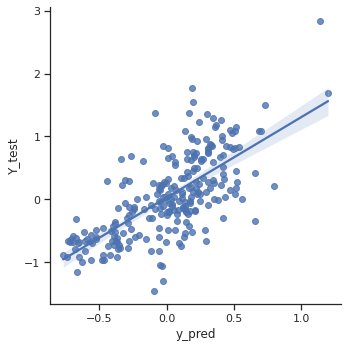

1
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
250
2-fold :  62.0
3-fold :  78.0
5-fold :  88.4
gmfe :  2.1263874284312707
mfe :  1.2661969579116046
bias :  0.05976061304455066
rmse  0.4387713937991339
r2  0.48433402115996704
saving model


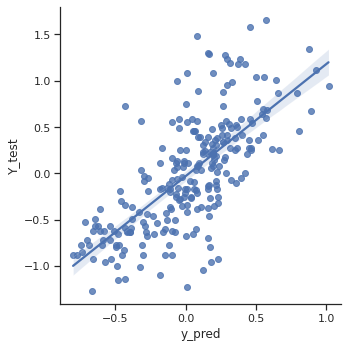

2
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
250
2-fold :  57.99999999999999
3-fold :  72.39999999999999
5-fold :  86.0
gmfe :  2.322989824664634
mfe :  1.2911609821494763
bias :  -0.03632342898072946
rmse  0.49757489925786635
r2  0.43003130321478933


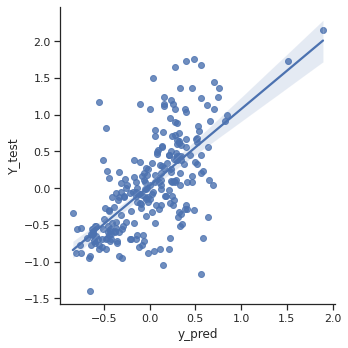

3
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
250
2-fold :  54.800000000000004
3-fold :  73.2
5-fold :  87.2
gmfe :  2.208533913578717
mfe :  1.3085137370874593
bias :  0.03844910936472934
rmse  0.4490617598362773
r2  0.5184911769694217


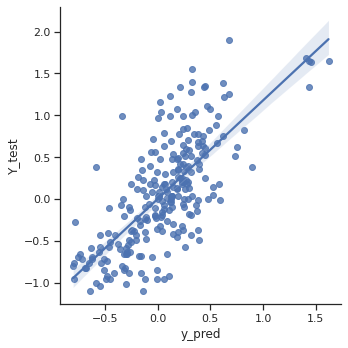

4
(1000, 152)
(249, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
249
2-fold :  48.99598393574297
3-fold :  70.68273092369478
5-fold :  86.34538152610442
gmfe :  2.4049947082906074
mfe :  1.358848351169693
bias :  0.11781093576620999
rmse  0.492262766832618
r2  0.3719356556124219


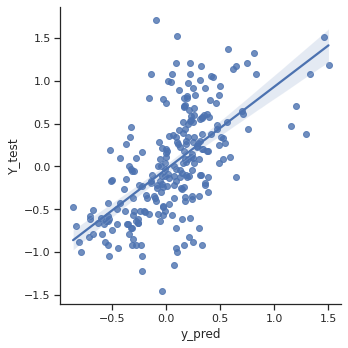

0
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
250
2-fold :  54.0
3-fold :  71.6
5-fold :  85.6
gmfe :  2.2173834224725573
mfe :  1.3117204021935127
bias :  0.02414986288007312
rmse  0.462230970086708
r2  0.41508773812634436


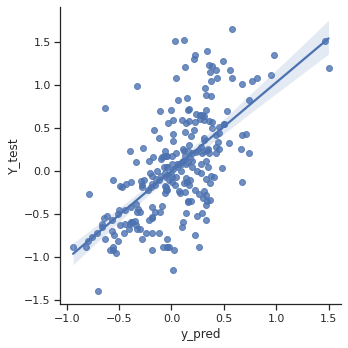

1
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
250
2-fold :  53.2
3-fold :  70.8
5-fold :  83.2
gmfe :  2.440777937722184
mfe :  1.3178576372619986
bias :  0.038281130385294584
rmse  0.5136152216483825
r2  0.42638375096426817


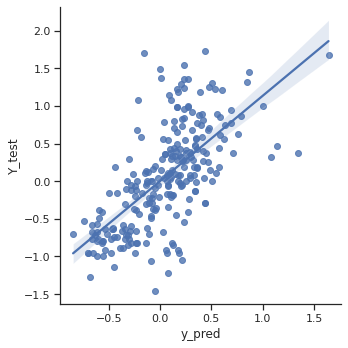

2
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
250
2-fold :  54.400000000000006
3-fold :  74.8
5-fold :  87.2
gmfe :  2.23282205030383
mfe :  1.309585085378134
bias :  0.006385631394310656
rmse  0.46847614790360526
r2  0.4411839345745313


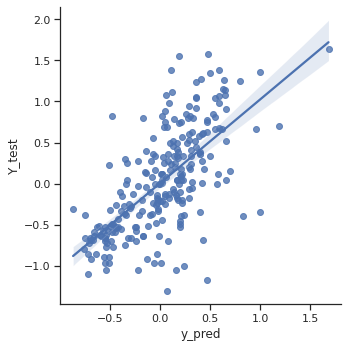

3
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
250
2-fold :  59.599999999999994
3-fold :  76.8
5-fold :  87.6
gmfe :  2.1560827412200063
mfe :  1.2844191871568065
bias :  0.05405831959578267
rmse  0.4508741440278589
r2  0.4988672950954549


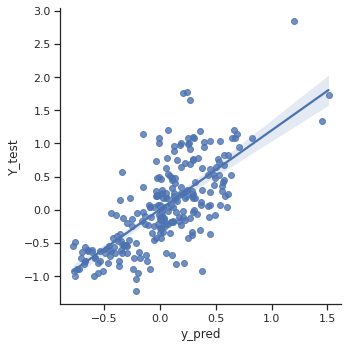

4
(1000, 152)
(249, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
249
2-fold :  55.42168674698795
3-fold :  72.28915662650603
5-fold :  86.34538152610442
gmfe :  2.2314839803863085
mfe :  1.314692159482771
bias :  0.03508615879354521
rmse  0.46160921758443013
r2  0.4936344198686198


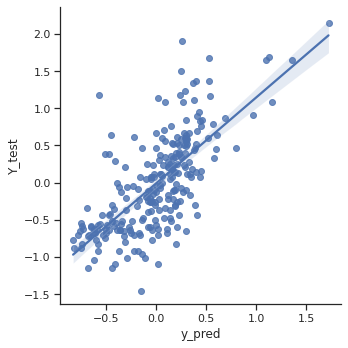

0
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
250
2-fold :  53.2
3-fold :  73.2
5-fold :  83.6
gmfe :  2.32501537423372
mfe :  1.304588017050262
bias :  0.021929074184469224
rmse  0.4840799261978047
r2  0.4274567638218213


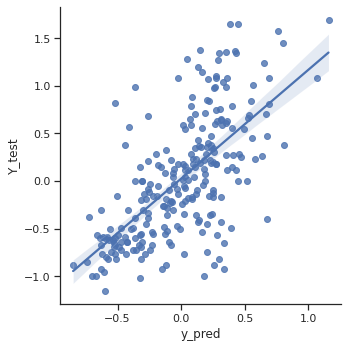

1
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=44)
250
2-fold :  55.2
3-fold :  70.0
5-fold :  89.2
gmfe :  2.3154455978451276
mfe :  1.2988172043550013
bias :  0.049322000129329496
rmse  0.4828162867543736
r2  0.4855772295398221


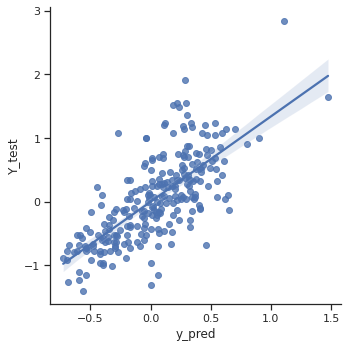

2
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
250
2-fold :  56.00000000000001
3-fold :  73.6
5-fold :  86.8
gmfe :  2.2177801412240634
mfe :  1.3057520895803603
bias :  0.04604501913442652
rmse  0.45904532089528444
r2  0.49567112296387794


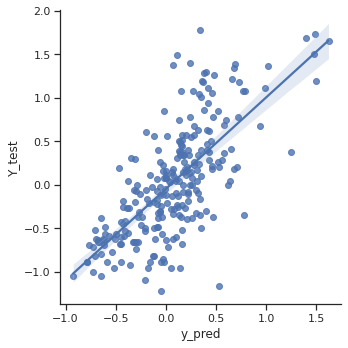

3
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
250
2-fold :  55.2
3-fold :  74.0
5-fold :  86.0
gmfe :  2.257060287720547
mfe :  1.2991550845525273
bias :  0.040574974511037004
rmse  0.4710883106410249
r2  0.3907263001740947


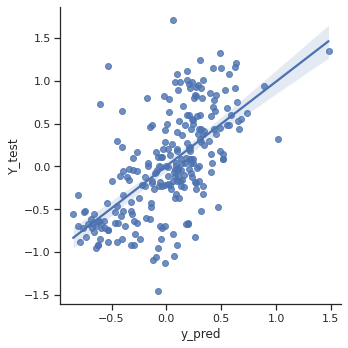

4
(1000, 152)
(249, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
249
2-fold :  59.83935742971887
3-fold :  78.3132530120482
5-fold :  87.55020080321285
gmfe :  2.142177488626917
mfe :  1.264080354476964
bias :  0.025998836260426872
rmse  0.44955966796115265
r2  0.4967288657508506


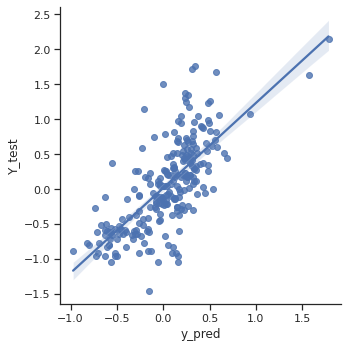

0
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
250
2-fold :  56.00000000000001
3-fold :  74.4
5-fold :  85.6
gmfe :  2.2747826175816015
mfe :  1.287690049214837
bias :  0.0036434026693724364
rmse  0.4858547458656687
r2  0.4296068129077375


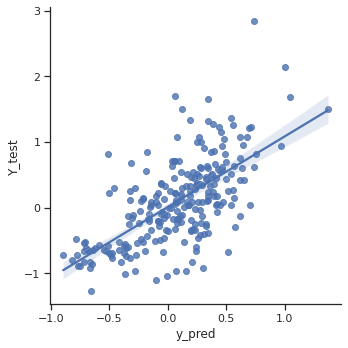

1
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
250
2-fold :  55.60000000000001
3-fold :  74.8
5-fold :  88.4
gmfe :  2.188195564466507
mfe :  1.2797030117677863
bias :  0.04840477685132761
rmse  0.45292101361358594
r2  0.4186801954804704


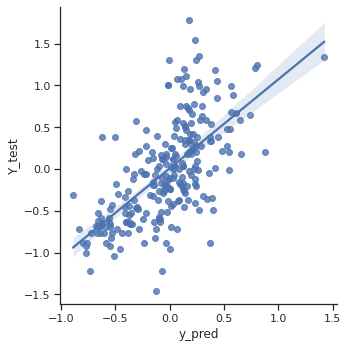

2
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
250
2-fold :  53.6
3-fold :  71.2
5-fold :  83.2
gmfe :  2.422695706689611
mfe :  1.3269438905535176
bias :  -0.007653725316047577
rmse  0.5145256654991758
r2  0.4202912180121188


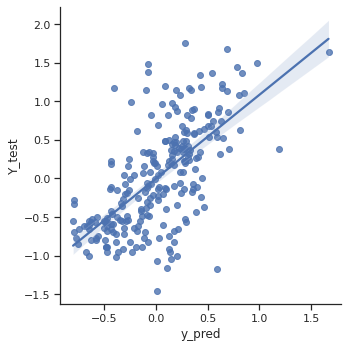

3
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
250
2-fold :  52.400000000000006
3-fold :  72.39999999999999
5-fold :  84.39999999999999
gmfe :  2.269457739744656
mfe :  1.3286149551416613
bias :  0.10800614417873775
rmse  0.46031897165512475
r2  0.46233683625722943


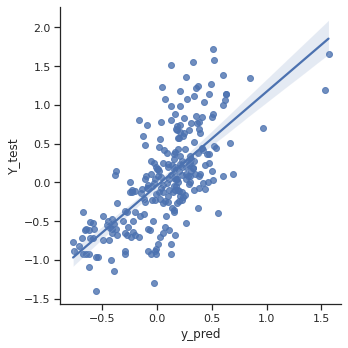

4
(1000, 152)
(249, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
249
2-fold :  58.63453815261044
3-fold :  78.3132530120482
5-fold :  89.5582329317269
gmfe :  2.10176633023512
mfe :  1.2782196442564497
bias :  0.055282727349281385
rmse  0.4292717410390643
r2  0.5647958478062154
saving model


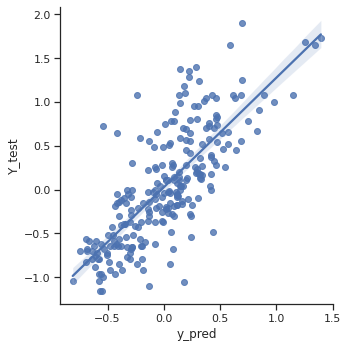

0
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
250
2-fold :  54.400000000000006
3-fold :  73.6
5-fold :  86.8
gmfe :  2.2407660107453102
mfe :  1.3007689745682114
bias :  0.03604676151452642
rmse  0.4572365858602946
r2  0.4643892275187569


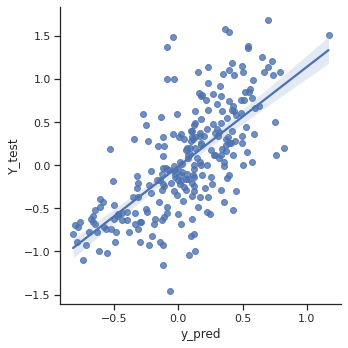

1
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
250
2-fold :  55.60000000000001
3-fold :  72.8
5-fold :  86.0
gmfe :  2.2571180665087605
mfe :  1.2947786347459855
bias :  0.07861569521414061
rmse  0.4764479768639929
r2  0.46397158208087275


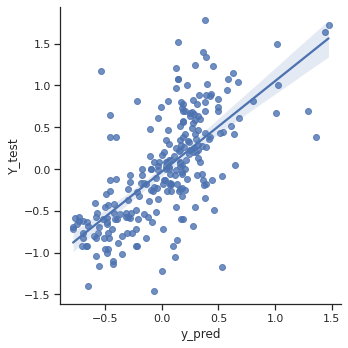

2
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
250
2-fold :  58.8
3-fold :  74.8
5-fold :  86.4
gmfe :  2.2037620261121327
mfe :  1.2849515799711897
bias :  0.03915079223863448
rmse  0.4609214295695655
r2  0.4762717776295651


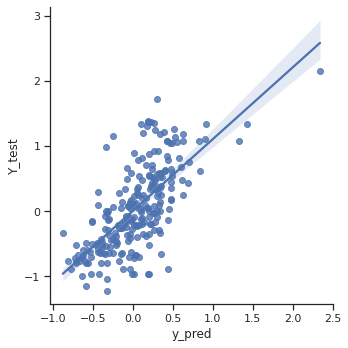

3
(999, 152)
(250, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
250
2-fold :  50.0
3-fold :  73.6
5-fold :  87.6
gmfe :  2.2940505442553727
mfe :  1.3439702262724005
bias :  -0.018987699732026575
rmse  0.47054041233958005
r2  0.4779922174975826


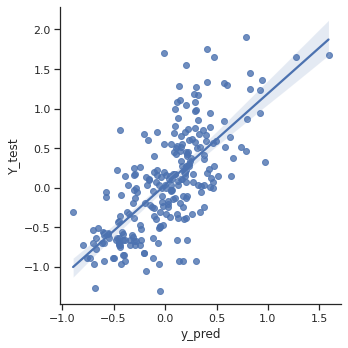

4
(1000, 152)
(249, 152)
Running ____________________human_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
249
2-fold :  55.020080321285135
3-fold :  74.29718875502009
5-fold :  86.34538152610442
gmfe :  2.219776019184918
mfe :  1.2989578611381343
bias :  0.035247688844492475
rmse  0.46329893539311506
r2  0.4646168619434462


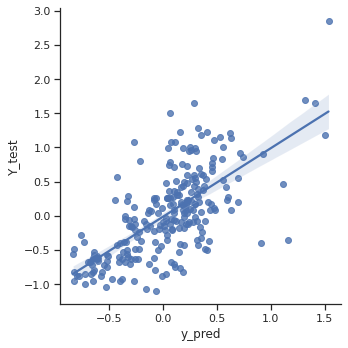

human_CL_mL_min_kg
0
(1024, 152)
(257, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
257
2-fold :  47.85992217898833
3-fold :  69.64980544747081
5-fold :  85.21400778210116
gmfe :  2.6767520582601154
mfe :  1.3621933491135672
bias :  -0.47324999061118955
rmse  0.5973575202017514
r2  0.2175639008669391
saving model


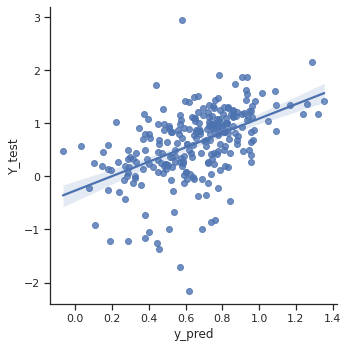

1
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
256
2-fold :  47.65625
3-fold :  67.1875
5-fold :  83.203125
gmfe :  2.6345027570485677
mfe :  1.3804538482215407
bias :  -0.4371231800822519
rmse  0.5647639682354046
r2  0.2148568858441513
saving model


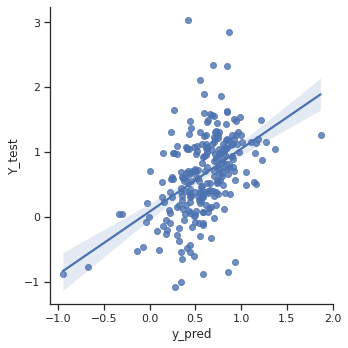

2
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
256
2-fold :  48.4375
3-fold :  71.484375
5-fold :  85.9375
gmfe :  2.47127549431107
mfe :  1.3655518338499812
bias :  -0.4336031577517243
rmse  0.5339568026634222
r2  0.21009705367842624
saving model


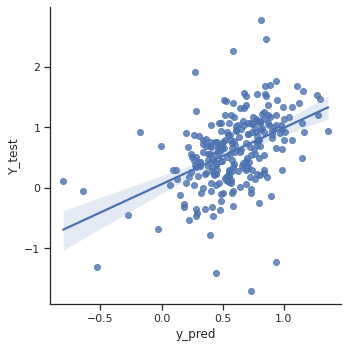

3
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
256
2-fold :  46.484375
3-fold :  69.53125
5-fold :  84.375
gmfe :  2.536458165369634
mfe :  1.3828103601550403
bias :  -0.5155593451912972
rmse  0.5404608687615184
r2  0.3248642417630401


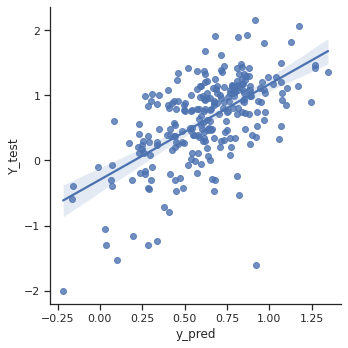

4
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=42)
256
2-fold :  48.4375
3-fold :  67.578125
5-fold :  82.8125
gmfe :  2.603430953387623
mfe :  1.3635130872210464
bias :  -0.12859305724794656
rmse  0.5844297848752397
r2  0.23696841999165386


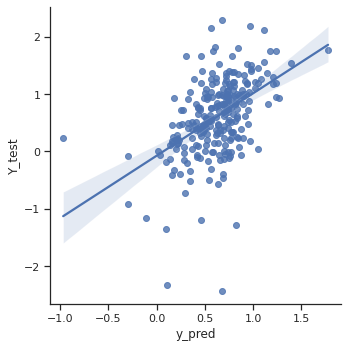

0
(1024, 152)
(257, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
257
2-fold :  48.63813229571984
3-fold :  66.9260700389105
5-fold :  80.93385214007782
gmfe :  2.757640283074035
mfe :  1.365025283298414
bias :  -0.21316680693425405
rmse  0.6174002768476169
r2  0.24808927466609365


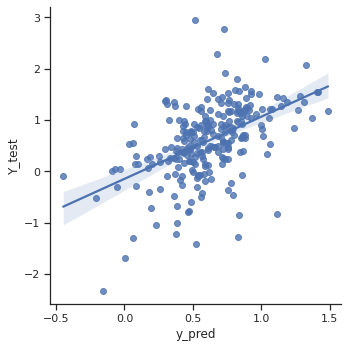

1
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
256
2-fold :  45.3125
3-fold :  63.671875
5-fold :  83.59375
gmfe :  2.8017522877945122
mfe :  1.4146586427637071
bias :  -0.48743072806258836
rmse  0.6175203903438806
r2  0.23803081612299337


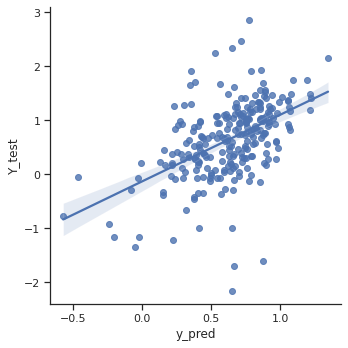

2
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
256
2-fold :  46.875
3-fold :  67.96875
5-fold :  84.765625
gmfe :  2.5113895900485907
mfe :  1.3692487749980964
bias :  -0.29992072125962477
rmse  0.5417488953081618
r2  0.18779851427717165


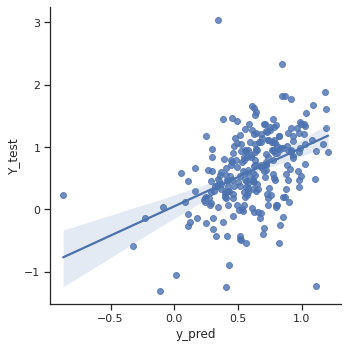

3
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
256
2-fold :  49.609375
3-fold :  69.921875
5-fold :  86.328125
gmfe :  2.467916509238845
mfe :  1.3559018344519136
bias :  -0.768336550074353
rmse  0.5146648734132312
r2  0.2729923198728409
saving model


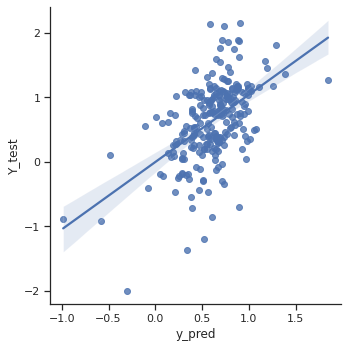

4
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
256
2-fold :  51.5625
3-fold :  72.65625
5-fold :  88.28125
gmfe :  2.3610412507748144
mfe :  1.338497013093868
bias :  -0.4141005930761201
rmse  0.501697221527342
r2  0.31967828114008356
saving model


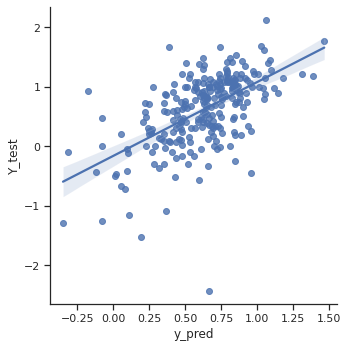

0
(1024, 152)
(257, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
257
2-fold :  53.30739299610895
3-fold :  73.54085603112841
5-fold :  85.60311284046692
gmfe :  2.3969763991825492
mfe :  1.3193516004754013
bias :  -0.839616364885515
rmse  0.5133513314724406
r2  0.3481029292660254


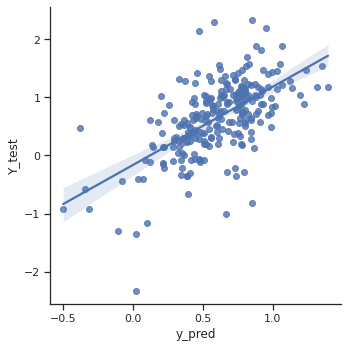

1
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
256
2-fold :  51.171875
3-fold :  70.3125
5-fold :  85.546875
gmfe :  2.4336183856056124
mfe :  1.3340195192384423
bias :  -0.7875119364946168
rmse  0.5253097797845209
r2  0.30027446682688474


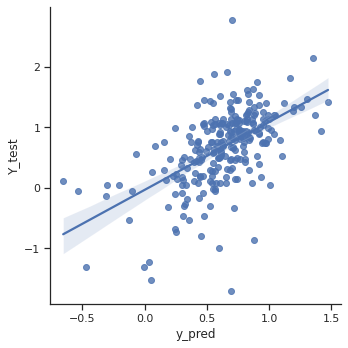

2
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
256
2-fold :  43.75
3-fold :  67.96875
5-fold :  82.03125
gmfe :  2.6973793930981382
mfe :  1.3966125657859907
bias :  0.11970780269750958
rmse  0.5863354870428099
r2  0.23992393145402313


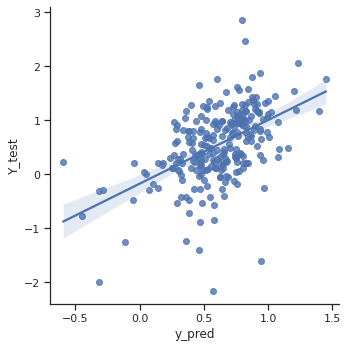

3
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
256
2-fold :  47.265625
3-fold :  66.40625
5-fold :  83.203125
gmfe :  2.765729413854471
mfe :  1.3620706177951418
bias :  -0.22369260716276362
rmse  0.6143276167307724
r2  0.17556335377055976


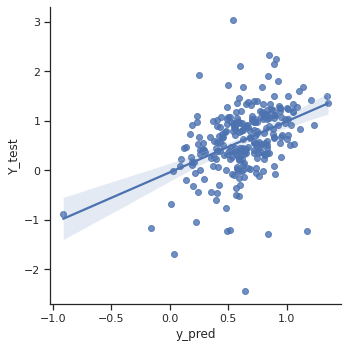

4
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
256
2-fold :  46.09375
3-fold :  64.0625
5-fold :  83.59375
gmfe :  2.566825993520305
mfe :  1.3725243782547236
bias :  -0.5705706478235737
rmse  0.5394314804019631
r2  0.25023173067299154


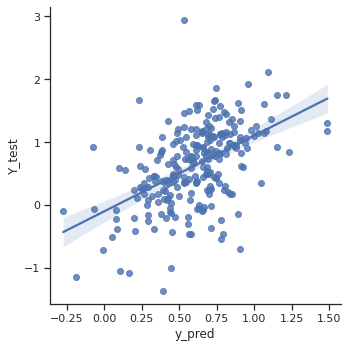

0
(1024, 152)
(257, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
257
2-fold :  47.081712062256805
3-fold :  67.70428015564202
5-fold :  86.38132295719845
gmfe :  2.4343941949203542
mfe :  1.372204651335231
bias :  -0.8975853823716311
rmse  0.4874348714643694
r2  0.2866724001623827


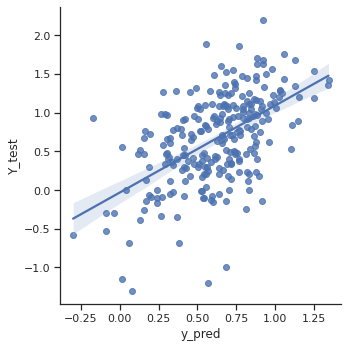

1
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  50.78125
3-fold :  70.3125
5-fold :  84.765625
gmfe :  2.4604939226140607
mfe :  1.3438422360129338
bias :  0.13471680576110523
rmse  0.5073609008882428
r2  0.30996447295896545


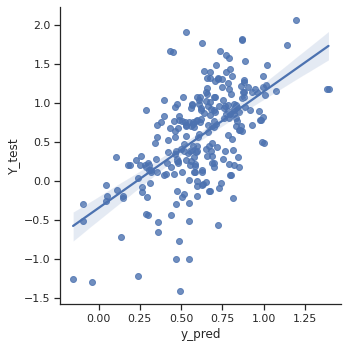

2
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  48.828125
3-fold :  66.796875
5-fold :  83.984375
gmfe :  2.669879793625344
mfe :  1.3930267064468593
bias :  -0.9414172572128395
rmse  0.5959380052541251
r2  0.20133977812706738


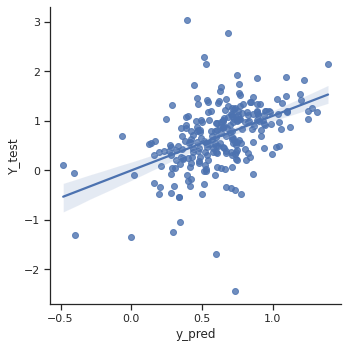

3
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=45)
256
2-fold :  54.6875
3-fold :  71.09375
5-fold :  85.15625
gmfe :  2.462100453439119
mfe :  1.2956324657617366
bias :  -0.3236117771048581
rmse  0.5577371906392842
r2  0.2407759664037381


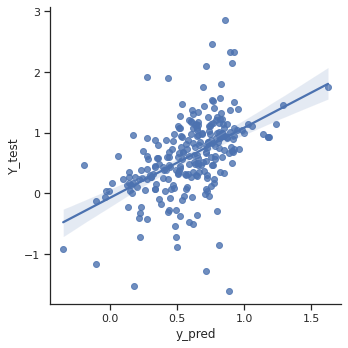

4
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
256
2-fold :  47.65625
3-fold :  67.96875
5-fold :  83.203125
gmfe :  2.763343811325577
mfe :  1.371899483182221
bias :  -0.0006888382650449554
rmse  0.6336434943815638
r2  0.24604028675186684


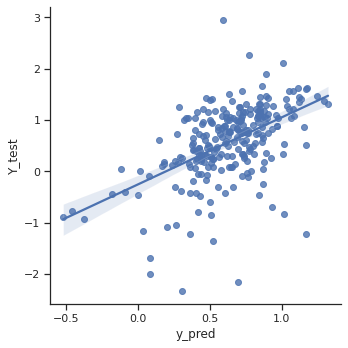

0
(1024, 152)
(257, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
257
2-fold :  45.91439688715953
3-fold :  68.8715953307393
5-fold :  85.21400778210116
gmfe :  2.5828589887316085
mfe :  1.4013490603601568
bias :  -0.9523233848714145
rmse  0.5708823874140383
r2  0.1907074945743612


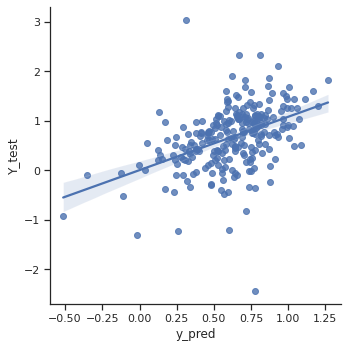

1
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
256
2-fold :  44.140625
3-fold :  63.28125
5-fold :  80.46875
gmfe :  2.843168959729975
mfe :  1.4005997561170707
bias :  -0.34278639925909626
rmse  0.622514793474083
r2  0.24445896424799118


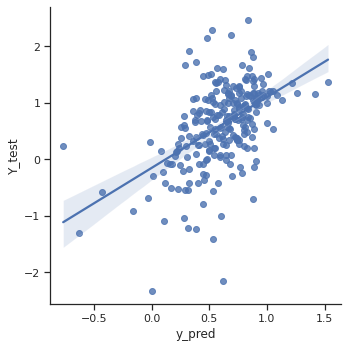

2
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
256
2-fold :  51.171875
3-fold :  72.65625
5-fold :  82.8125
gmfe :  2.616552600905431
mfe :  1.3438893642937662
bias :  0.24444948842949799
rmse  0.5984341580292117
r2  0.18489831762486997


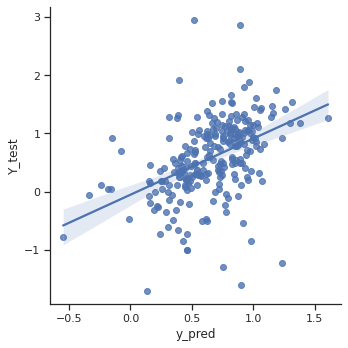

3
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
256
2-fold :  48.4375
3-fold :  67.578125
5-fold :  85.546875
gmfe :  2.5093050577110003
mfe :  1.3711259409684236
bias :  -0.23206829212422764
rmse  0.5354823213563058
r2  0.3128058189222792


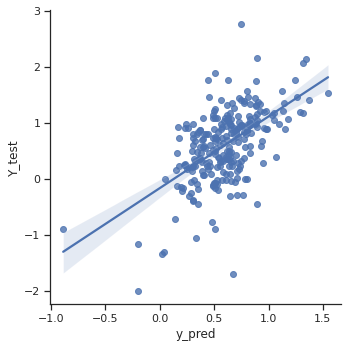

4
(1025, 152)
(256, 152)
Running ____________________human_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
256
2-fold :  51.953125
3-fold :  75.0
5-fold :  90.234375
gmfe :  2.2592547018854585
mfe :  1.3373045869411846
bias :  -0.6982387710065139
rmse  0.46042448300699657
r2  0.3533359994316523
saving model


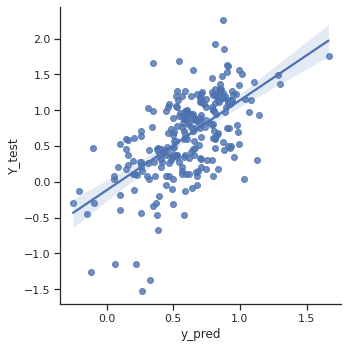

human_fup
0
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
176
2-fold :  42.04545454545455
3-fold :  59.09090909090909
5-fold :  71.5909090909091
gmfe :  3.9132211524099145
mfe :  1.4363191435961542
bias :  0.09082767165059567
rmse  0.27130320205254405
r2  0.4034823026865384
saving model


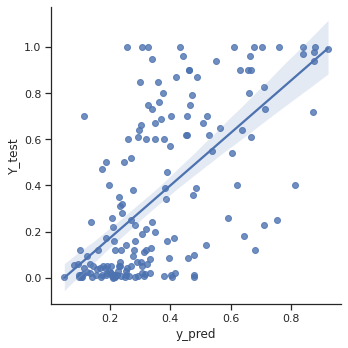

1
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
176
2-fold :  50.0
3-fold :  66.47727272727273
5-fold :  77.27272727272727
gmfe :  3.339613913812743
mfe :  1.3556780005807323
bias :  0.09126787016576567
rmse  0.2403244057152926
r2  0.429995389743275
saving model


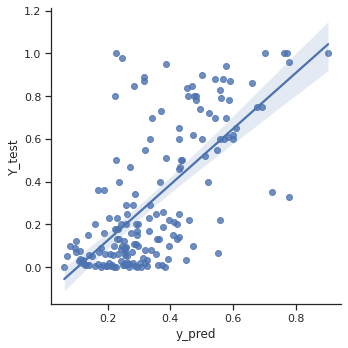

2
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
176
2-fold :  47.159090909090914
3-fold :  67.04545454545455
5-fold :  80.11363636363636
gmfe :  3.088162268207232
mfe :  1.3661204386574664
bias :  0.02609355389221675
rmse  0.28280606975841643
r2  0.3343365112620903
saving model


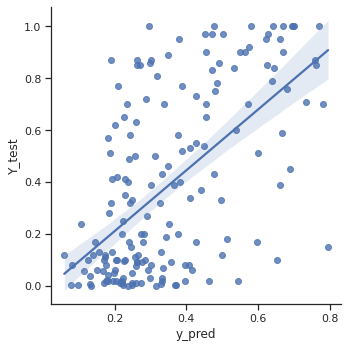

3
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
176
2-fold :  45.45454545454545
3-fold :  62.5
5-fold :  72.72727272727273
gmfe :  3.2999216247149987
mfe :  1.4060132916914057
bias :  0.060201017849825324
rmse  0.26440536465246145
r2  0.41705754214930013


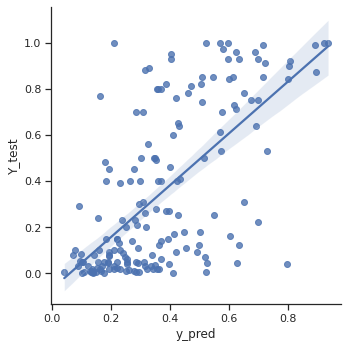

4
(704, 152)
(175, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
175
2-fold :  47.42857142857143
3-fold :  60.0
5-fold :  70.85714285714285
gmfe :  3.400857110756964
mfe :  1.3699949096788495
bias :  0.08957452177958841
rmse  0.2510144320876589
r2  0.4415122823189688


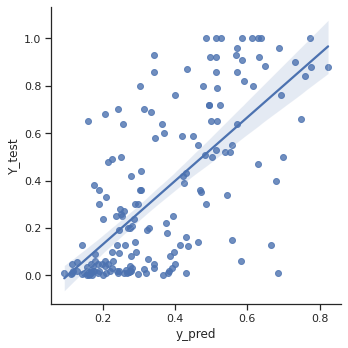

0
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
176
2-fold :  44.31818181818182
3-fold :  61.93181818181818
5-fold :  73.29545454545455
gmfe :  3.442666413458061
mfe :  1.4280875529860264
bias :  0.07844920245859272
rmse  0.2587395846740766
r2  0.4168243624012239


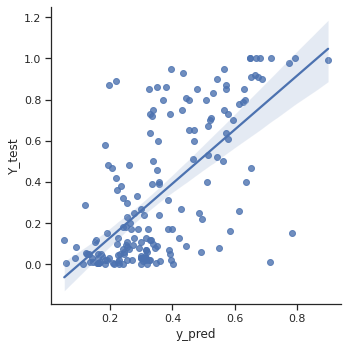

1
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
176
2-fold :  52.27272727272727
3-fold :  64.77272727272727
5-fold :  74.43181818181817
gmfe :  3.2691985075759495
mfe :  1.3162619528526278
bias :  0.07418932226991018
rmse  0.2416104943316198
r2  0.43424060012396914


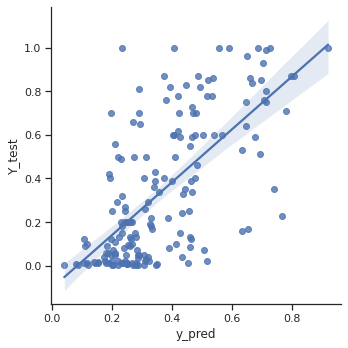

2
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
176
2-fold :  43.18181818181818
3-fold :  61.36363636363637
5-fold :  72.1590909090909
gmfe :  3.7956822488489603
mfe :  1.433743337898734
bias :  0.0548757782908461
rmse  0.28698780431467286
r2  0.3960473700829722


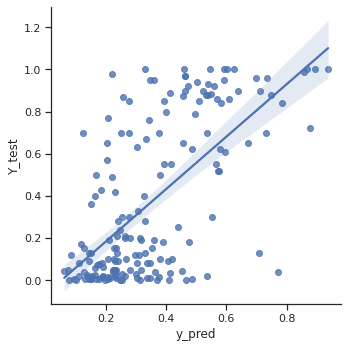

3
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=43)
176
2-fold :  44.31818181818182
3-fold :  63.63636363636363
5-fold :  76.13636363636364
gmfe :  3.540762270156641
mfe :  1.4241962436119437
bias :  0.07043301109374223
rmse  0.2807354857262147
r2  0.3786921336509381


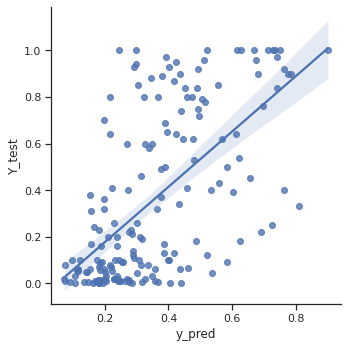

4
(704, 152)
(175, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
175
2-fold :  49.714285714285715
3-fold :  62.857142857142854
5-fold :  75.42857142857143
gmfe :  2.991532029627036
mfe :  1.3514568519406793
bias :  0.051724785012711265
rmse  0.23268370944794464
r2  0.4469373416279466
saving model


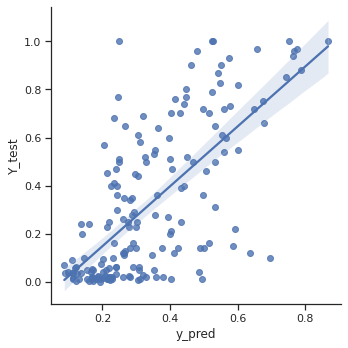

0
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
176
2-fold :  51.13636363636363
3-fold :  61.93181818181818
5-fold :  74.43181818181817
gmfe :  3.1519189597200206
mfe :  1.3276448928626945
bias :  0.06640218367632118
rmse  0.26132414132550247
r2  0.43990765340684157


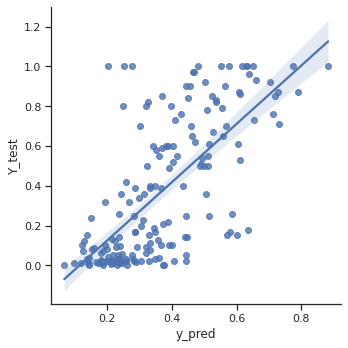

1
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
176
2-fold :  46.590909090909086
3-fold :  61.93181818181818
5-fold :  73.29545454545455
gmfe :  3.3585810422566524
mfe :  1.3819056726057275
bias :  0.05129688764267534
rmse  0.2583984981167411
r2  0.3889876541156375


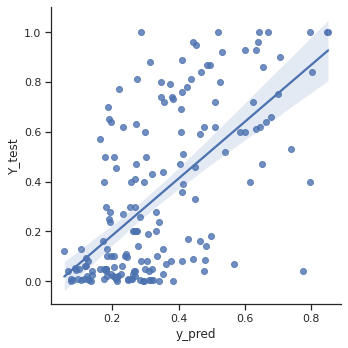

2
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=44)
176
2-fold :  50.56818181818182
3-fold :  64.20454545454545
5-fold :  76.13636363636364
gmfe :  3.526848096686499
mfe :  1.3483440446184063
bias :  0.07709030196690625
rmse  0.2657399230583342
r2  0.385468126971224


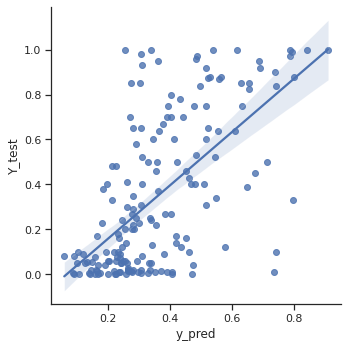

3
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=44)
176
2-fold :  44.88636363636363
3-fold :  65.3409090909091
5-fold :  76.13636363636364
gmfe :  3.4904453951571655
mfe :  1.388243268471494
bias :  0.04680811538824569
rmse  0.2670148587161813
r2  0.4253768040443574


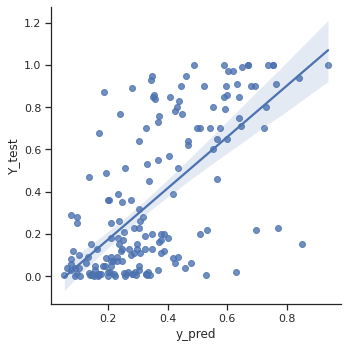

4
(704, 152)
(175, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
175
2-fold :  44.57142857142857
3-fold :  60.0
5-fold :  73.14285714285714
gmfe :  3.28320294454053
mfe :  1.4226836207561688
bias :  0.09019172915992658
rmse  0.24732746378770765
r2  0.4384409688738694


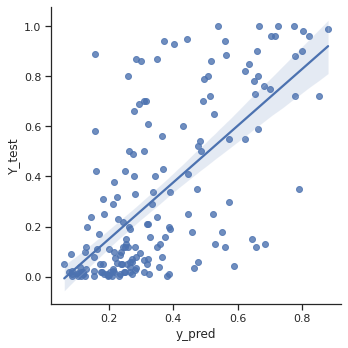

0
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
176
2-fold :  44.88636363636363
3-fold :  56.25
5-fold :  70.45454545454545
gmfe :  3.883777172741227
mfe :  1.467150693698426
bias :  0.11598045699803455
rmse  0.2640987932567971
r2  0.2545719995601403


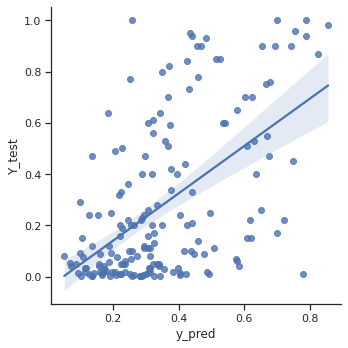

1
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
176
2-fold :  47.72727272727273
3-fold :  63.06818181818182
5-fold :  74.43181818181817
gmfe :  3.068444913095773
mfe :  1.3731530502074192
bias :  0.046021888880973444
rmse  0.2731284946165615
r2  0.3553532446698966


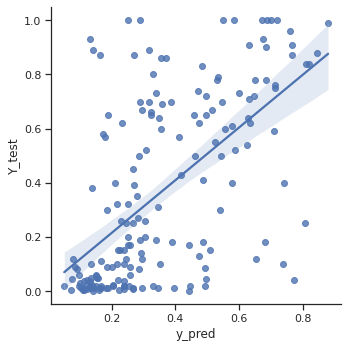

2
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
176
2-fold :  52.27272727272727
3-fold :  64.77272727272727
5-fold :  75.0
gmfe :  3.232893898358002
mfe :  1.3103878712603658
bias :  0.022717714991862495
rmse  0.26293191290356754
r2  0.45330515967747165


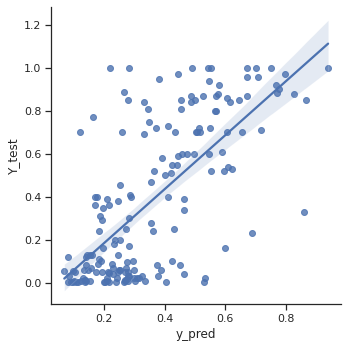

3
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
176
2-fold :  50.0
3-fold :  63.06818181818182
5-fold :  77.27272727272727
gmfe :  3.2244009960952407
mfe :  1.3517986197240537
bias :  0.08474206962860617
rmse  0.2463283292274817
r2  0.46644961676387997


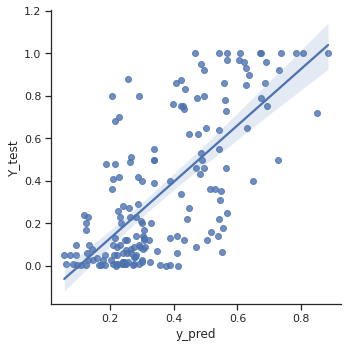

4
(704, 152)
(175, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
175
2-fold :  46.85714285714286
3-fold :  65.71428571428571
5-fold :  75.42857142857143
gmfe :  3.417786667684562
mfe :  1.3724530981651022
bias :  0.051541267969611955
rmse  0.2674055894148742
r2  0.4251687450850453


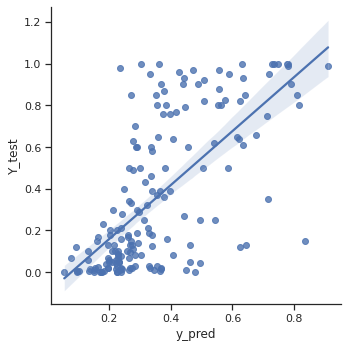

0
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
176
2-fold :  43.18181818181818
3-fold :  60.22727272727273
5-fold :  69.88636363636364
gmfe :  3.7716059977387295
mfe :  1.4221398622173191
bias :  0.08637822125383109
rmse  0.2758144055445483
r2  0.3781530724655052


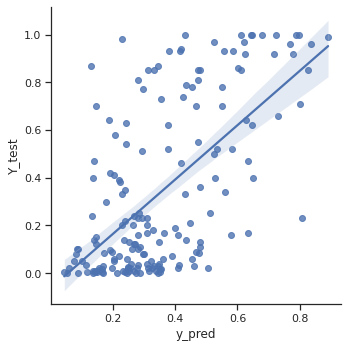

1
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=46)
176
2-fold :  47.72727272727273
3-fold :  66.47727272727273
5-fold :  77.8409090909091
gmfe :  3.2957605828997103
mfe :  1.3631832365197851
bias :  0.045007319323749836
rmse  0.2607093198772323
r2  0.38311260907398215


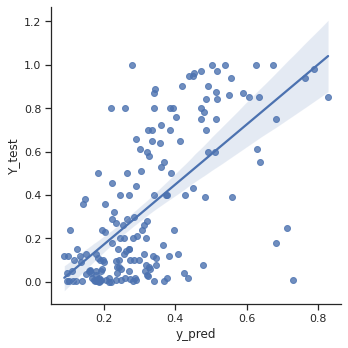

2
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=46)
176
2-fold :  47.72727272727273
3-fold :  62.5
5-fold :  72.1590909090909
gmfe :  3.3354580936376768
mfe :  1.3792738791941723
bias :  0.0563497743929532
rmse  0.2618891755826271
r2  0.4276684240990387


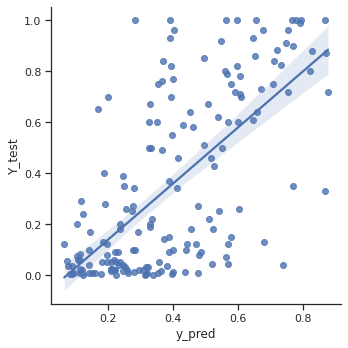

3
(703, 152)
(176, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
176
2-fold :  54.54545454545454
3-fold :  67.04545454545455
5-fold :  77.8409090909091
gmfe :  3.2382065634698876
mfe :  1.3168914756711991
bias :  0.0586890388304038
rmse  0.24159964897029282
r2  0.45946821466182497


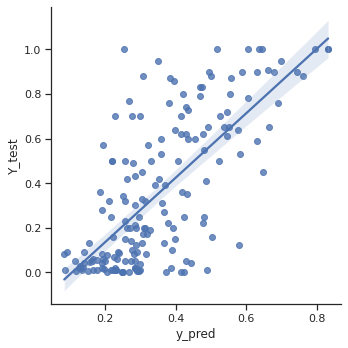

4
(704, 152)
(175, 152)
Running ____________________human_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=46)
175
2-fold :  45.714285714285715
3-fold :  58.857142857142854
5-fold :  72.57142857142857
gmfe :  3.3544765772803316
mfe :  1.4445824908419762
bias :  0.07972744008094518
rmse  0.25934783964456676
r2  0.4402327938523821


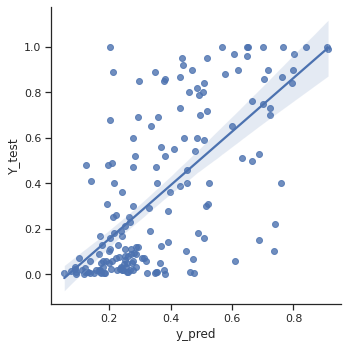

human_mrt
0
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=42)
249
2-fold :  46.58634538152611
3-fold :  67.46987951807229
5-fold :  81.92771084337349
gmfe :  2.6074693117794276
mfe :  1.4177125826322527
bias :  -0.1473144651560121
rmse  0.5442315403666829
r2  0.23021120897481095
saving model


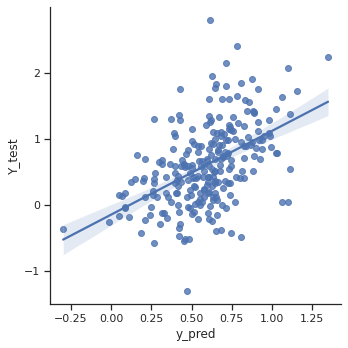

1
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
249
2-fold :  49.79919678714859
3-fold :  67.06827309236948
5-fold :  84.33734939759037
gmfe :  2.488859796349152
mfe :  1.3513366632756738
bias :  -0.07491359343938786
rmse  0.5310709766647894
r2  0.22320940774493436
saving model


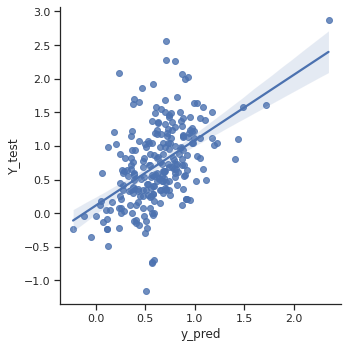

2
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
249
2-fold :  50.602409638554214
3-fold :  73.09236947791165
5-fold :  83.13253012048193
gmfe :  2.574677113082156
mfe :  1.338784404222823
bias :  -0.2878874927246029
rmse  0.5569024859256902
r2  0.29191091236941624


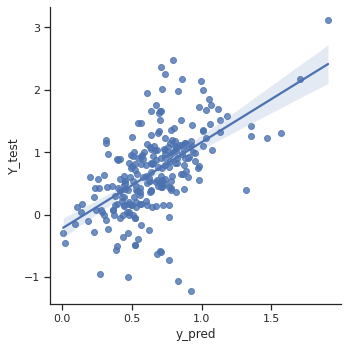

3
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=42)
248
2-fold :  50.0
3-fold :  64.51612903225806
5-fold :  80.24193548387096
gmfe :  2.7812757101420713
mfe :  1.3526921389226498
bias :  0.3654885830045188
rmse  0.6118666649336568
r2  0.2196495120326737


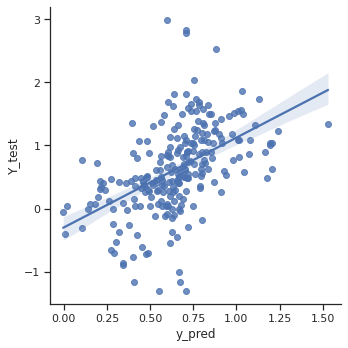

4
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)
248
2-fold :  48.79032258064516
3-fold :  66.53225806451613
5-fold :  80.64516129032258
gmfe :  2.60337364370935
mfe :  1.375663812951051
bias :  0.39054339958241024
rmse  0.5640220153886627
r2  0.1629920692886757


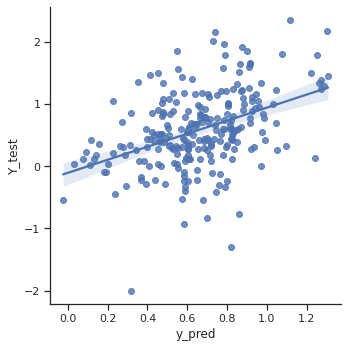

0
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=43)
249
2-fold :  47.389558232931726
3-fold :  69.07630522088354
5-fold :  83.53413654618474
gmfe :  2.6592508706346614
mfe :  1.380962546696904
bias :  -0.13428329698116026
rmse  0.5771669279408238
r2  0.19120923109948618


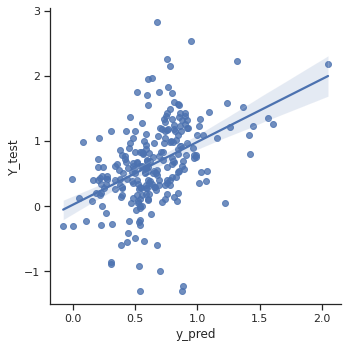

1
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=43)
249
2-fold :  46.1847389558233
3-fold :  62.24899598393574
5-fold :  79.11646586345381
gmfe :  2.7750282752673097
mfe :  1.4178820827571714
bias :  -0.09249652537592423
rmse  0.6029590115793628
r2  0.24617526611264406


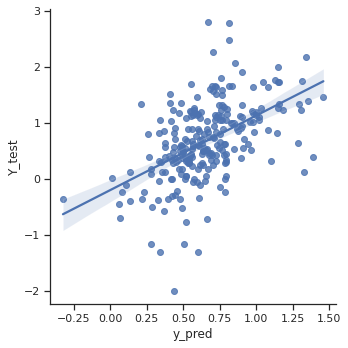

2
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=43)
249
2-fold :  48.59437751004016
3-fold :  65.06024096385542
5-fold :  84.73895582329317
gmfe :  2.5516322359568098
mfe :  1.3848582981427742
bias :  0.0842629388093109
rmse  0.5318077728347569
r2  0.24585437068064686


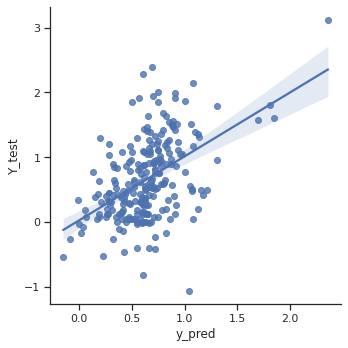

3
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=43)
248
2-fold :  47.17741935483871
3-fold :  68.14516129032258
5-fold :  81.45161290322581
gmfe :  2.6655182426670265
mfe :  1.3722074168349079
bias :  0.13150059070406317
rmse  0.5734709607660413
r2  0.24262588311314792


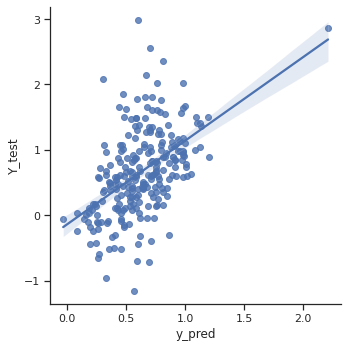

4
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
248
2-fold :  52.41935483870967
3-fold :  73.79032258064517
5-fold :  84.67741935483872
gmfe :  2.332659078472037
mfe :  1.3283806698034413
bias :  0.29813897375503906
rmse  0.48937507026174903
r2  0.31992660567747555
saving model


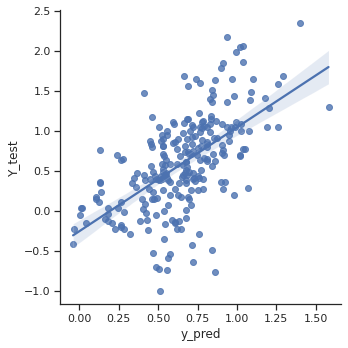

0
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
249
2-fold :  51.00401606425703
3-fold :  68.67469879518072
5-fold :  84.73895582329317
gmfe :  2.437256681675124
mfe :  1.3463914992343808
bias :  0.14898551744197652
rmse  0.5208668723279368
r2  0.22916199709032037


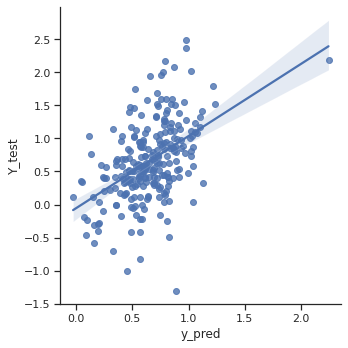

1
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
249
2-fold :  48.59437751004016
3-fold :  67.46987951807229
5-fold :  80.32128514056225
gmfe :  2.717398812167734
mfe :  1.3659374839557363
bias :  0.40432481360573647
rmse  0.595437534944789
r2  0.2602795302070259


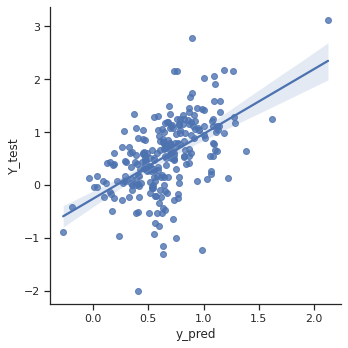

2
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
249
2-fold :  53.01204819277109
3-fold :  70.28112449799197
5-fold :  84.73895582329317
gmfe :  2.463390000665739
mfe :  1.3163590019806066
bias :  0.14248828264414937
rmse  0.5350758583376205
r2  0.2609272538992552


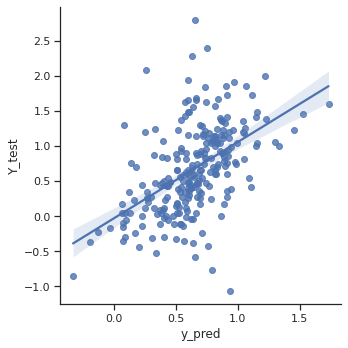

3
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
248
2-fold :  49.193548387096776
3-fold :  69.35483870967742
5-fold :  81.04838709677419
gmfe :  2.6574207311888784
mfe :  1.3647121315441553
bias :  0.1656612575536216
rmse  0.5631201467911602
r2  0.1902196281846582


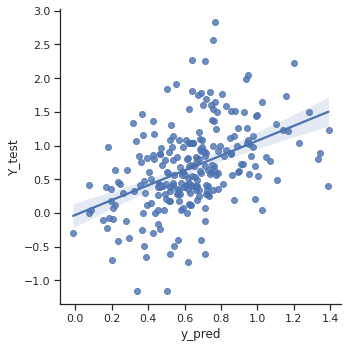

4
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
248
2-fold :  45.96774193548387
3-fold :  65.7258064516129
5-fold :  84.67741935483872
gmfe :  2.586713781736272
mfe :  1.396945741980932
bias :  -0.18056869407625198
rmse  0.5474501364852332
r2  0.31085706547653824


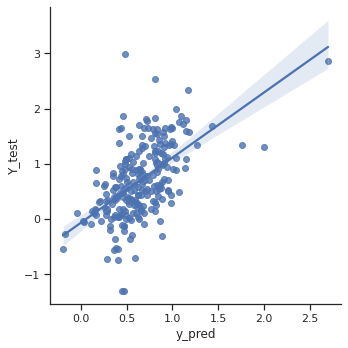

0
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=45)
249
2-fold :  48.59437751004016
3-fold :  67.06827309236948
5-fold :  83.13253012048193
gmfe :  2.6064852735041573
mfe :  1.3708384708109962
bias :  -0.6036348897023611
rmse  0.5656321344037577
r2  0.20329727408583087


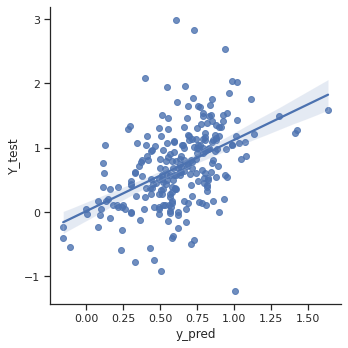

1
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=45)
249
2-fold :  44.17670682730924
3-fold :  65.46184738955823
5-fold :  79.51807228915662
gmfe :  2.7448714302094803
mfe :  1.4161656383153693
bias :  0.2967994855475602
rmse  0.5977746842914802
r2  0.2685108135700912


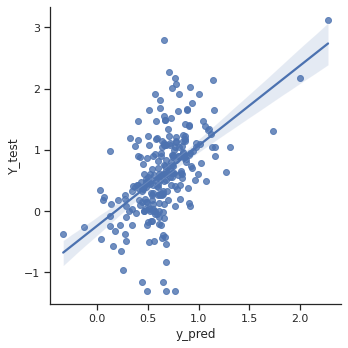

2
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
249
2-fold :  49.79919678714859
3-fold :  69.07630522088354
5-fold :  83.93574297188755
gmfe :  2.6019174044692335
mfe :  1.3520254353404624
bias :  -0.3151140788110709
rmse  0.5638423078938847
r2  0.2112200951899832


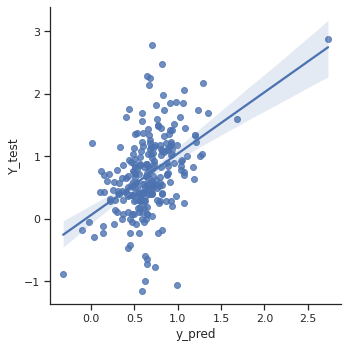

3
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
248
2-fold :  50.806451612903224
3-fold :  70.56451612903226
5-fold :  85.48387096774194
gmfe :  2.4270550709858183
mfe :  1.3355128356066077
bias :  0.1112729611088577
rmse  0.5035527461944226
r2  0.30213138444741294


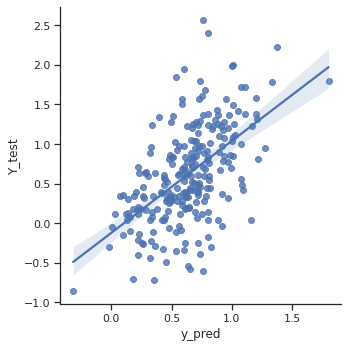

4
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
248
2-fold :  47.17741935483871
3-fold :  68.54838709677419
5-fold :  81.85483870967742
gmfe :  2.552442159785792
mfe :  1.367202565552188
bias :  0.3902650605699949
rmse  0.5402063134837802
r2  0.2512726944800504


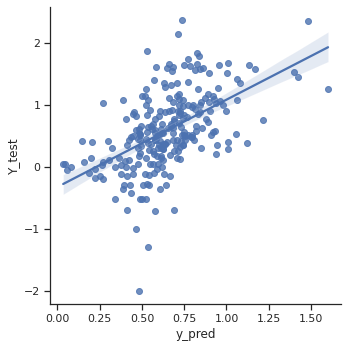

0
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
249
2-fold :  48.19277108433735
3-fold :  67.06827309236948
5-fold :  80.32128514056225
gmfe :  2.7050835633038637
mfe :  1.3580300813375592
bias :  0.13708083406482074
rmse  0.5709141984272461
r2  0.2779865580329226


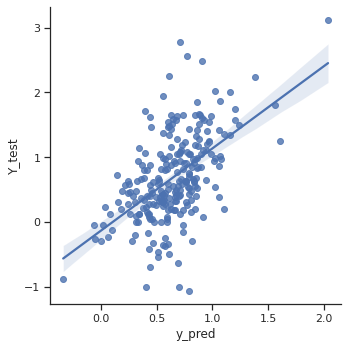

1
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=46)
249
2-fold :  47.791164658634536
3-fold :  67.46987951807229
5-fold :  84.33734939759037
gmfe :  2.5249694185800187
mfe :  1.3838484883780882
bias :  0.04630258412821853
rmse  0.5307408265754224
r2  0.2752726697991936


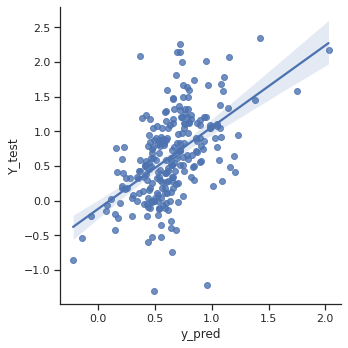

2
(994, 152)
(249, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=46)
249
2-fold :  51.40562248995983
3-fold :  72.28915662650603
5-fold :  87.55020080321285
gmfe :  2.391942481366869
mfe :  1.336387606027206
bias :  0.10817090541900765
rmse  0.5204580008433218
r2  0.2697839108293305


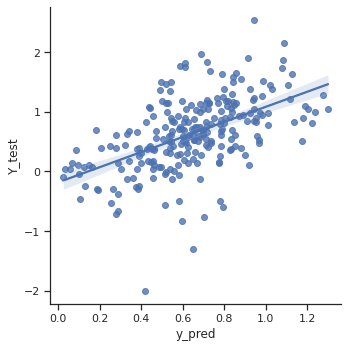

3
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
248
2-fold :  44.75806451612903
3-fold :  60.08064516129033
5-fold :  77.01612903225806
gmfe :  2.9981781098304876
mfe :  1.4374509250070326
bias :  -0.03957908033715585
rmse  0.6411736136570281
r2  0.12549629222919467


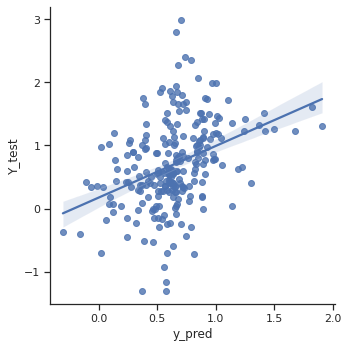

4
(995, 152)
(248, 152)
Running ____________________human_mrt MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
248
2-fold :  47.17741935483871
3-fold :  71.7741935483871
5-fold :  85.48387096774194
gmfe :  2.4612211880870154
mfe :  1.372082483273696
bias :  0.22460909911877386
rmse  0.5137076880268195
r2  0.2829256646475904


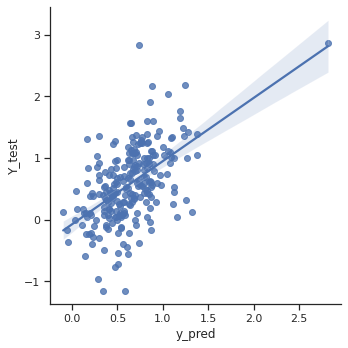

human_thalf
0
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
253
2-fold :  41.89723320158103
3-fold :  64.03162055335969
5-fold :  82.21343873517787
gmfe :  2.6811264776475254
mfe :  1.4364183083083415
bias :  -0.4288302498095784
rmse  0.5450371800716888
r2  0.24591950171255006
saving model


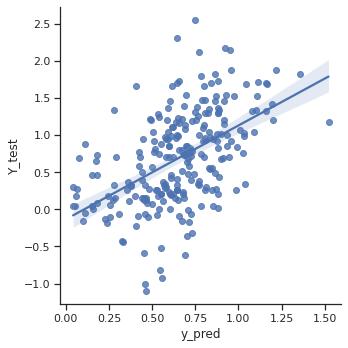

1
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
253
2-fold :  47.43083003952569
3-fold :  67.98418972332016
5-fold :  84.18972332015811
gmfe :  2.5344319812963563
mfe :  1.3827259342752525
bias :  0.3267105560638468
rmse  0.5275138348602194
r2  0.2799881664077484
saving model


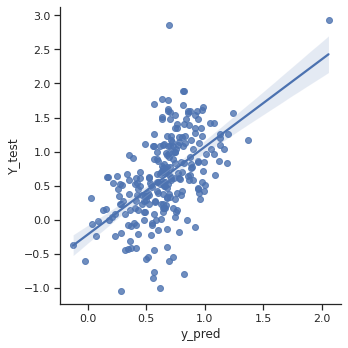

2
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=300,
                      n_jobs=30, random_state=42)
253
2-fold :  50.988142292490124
3-fold :  69.56521739130434
5-fold :  83.399209486166
gmfe :  2.4592672034486256
mfe :  1.3405118461836893
bias :  0.16156238695006886
rmse  0.51129407093015
r2  0.23190594883609728
saving model


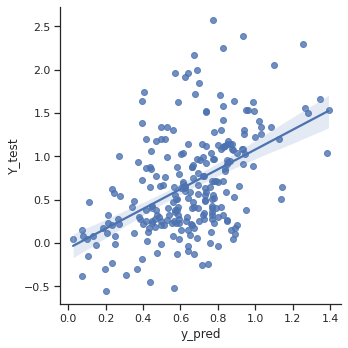

3
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
253
2-fold :  46.6403162055336
3-fold :  65.61264822134387
5-fold :  81.02766798418972
gmfe :  2.800271495758755
mfe :  1.3904685229899565
bias :  0.29983826208619735
rmse  0.6148757213953552
r2  0.22694018060433063


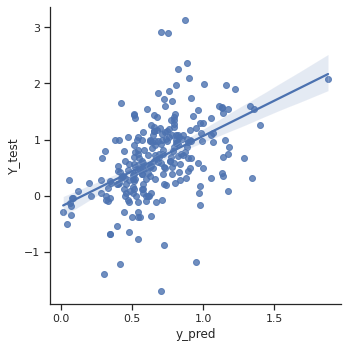

4
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
253
2-fold :  56.126482213438734
3-fold :  75.49407114624506
5-fold :  88.14229249011858
gmfe :  2.2311380110214656
mfe :  1.305679853512294
bias :  0.09421504968920236
rmse  0.471368012920075
r2  0.3220653986924754
saving model


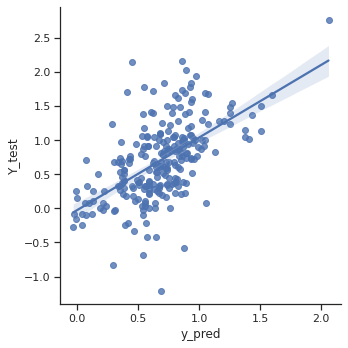

0
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=43)
253
2-fold :  51.38339920948617
3-fold :  70.35573122529645
5-fold :  85.37549407114624
gmfe :  2.3594522909248927
mfe :  1.3402692357073098
bias :  -0.010554875809409614
rmse  0.4857551847762772
r2  0.2582596663888894


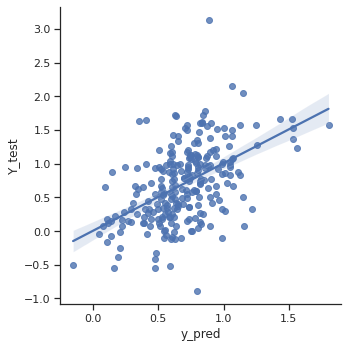

1
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  44.26877470355731
3-fold :  65.61264822134387
5-fold :  82.6086956521739
gmfe :  2.712023322489506
mfe :  1.4118968040673712
bias :  0.36924979847591444
rmse  0.5879776791531977
r2  0.22280601605296713


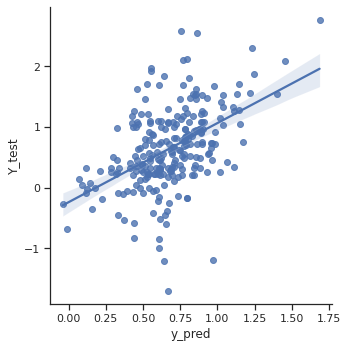

2
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=43)
253
2-fold :  48.22134387351779
3-fold :  69.1699604743083
5-fold :  83.00395256916995
gmfe :  2.550851693490577
mfe :  1.368421848357612
bias :  -0.05111272043912596
rmse  0.5439184976446779
r2  0.1985856884999001


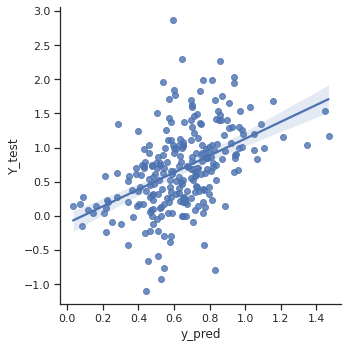

3
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=200,
                      n_jobs=30, random_state=43)
253
2-fold :  43.873517786561266
3-fold :  66.40316205533597
5-fold :  84.98023715415019
gmfe :  2.5812422106070283
mfe :  1.392921929667509
bias :  -0.05654208822161344
rmse  0.5276529510604061
r2  0.273538155481162


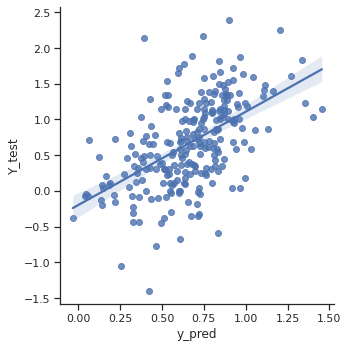

4
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
253
2-fold :  49.80237154150198
3-fold :  67.98418972332016
5-fold :  84.98023715415019
gmfe :  2.548272065483794
mfe :  1.3532171184661563
bias :  0.3050319163895352
rmse  0.543698352147669
r2  0.30197331977251496


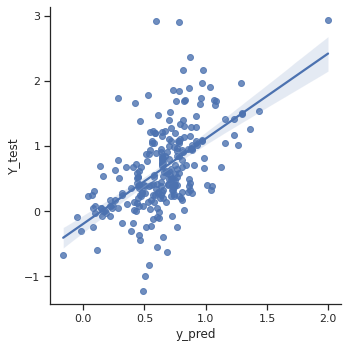

0
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
253
2-fold :  50.19762845849802
3-fold :  73.51778656126481
5-fold :  87.35177865612648
gmfe :  2.3337474258450643
mfe :  1.3510763829984649
bias :  0.29794050329253347
rmse  0.46593966550471505
r2  0.32912653000152114


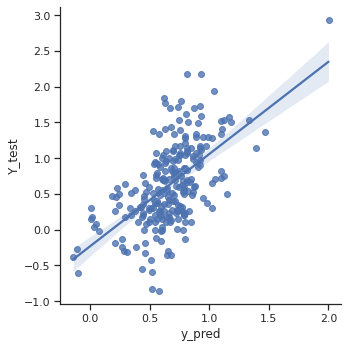

1
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
253
2-fold :  45.8498023715415
3-fold :  66.40316205533597
5-fold :  83.399209486166
gmfe :  2.6346117090311627
mfe :  1.4021046671979382
bias :  0.08612370628701149
rmse  0.5572164471538146
r2  0.26177630550452224


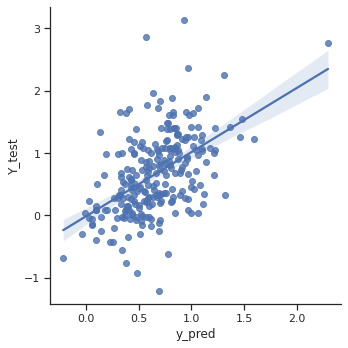

2
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=44)
253
2-fold :  50.19762845849802
3-fold :  69.1699604743083
5-fold :  88.93280632411067
gmfe :  2.4249019854522067
mfe :  1.3501831294444977
bias :  0.07914090306502475
rmse  0.5065614522175106
r2  0.28640068648777095


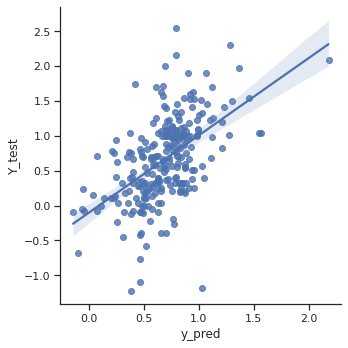

3
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=44)
253
2-fold :  47.03557312252965
3-fold :  66.00790513833992
5-fold :  80.63241106719367
gmfe :  2.7110268996693603
mfe :  1.3897209514515712
bias :  0.2400365964163601
rmse  0.5806554209623002
r2  0.22606978982283743


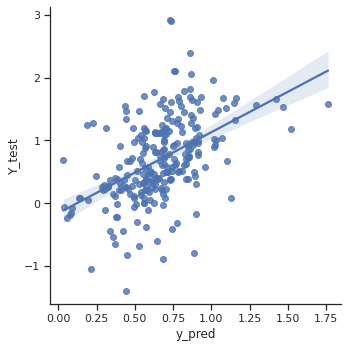

4
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
253
2-fold :  46.6403162055336
3-fold :  66.00790513833992
5-fold :  83.399209486166
gmfe :  2.6401999168386197
mfe :  1.409064497291462
bias :  -0.5024845620849101
rmse  0.5710427339368365
r2  0.18036217246340236


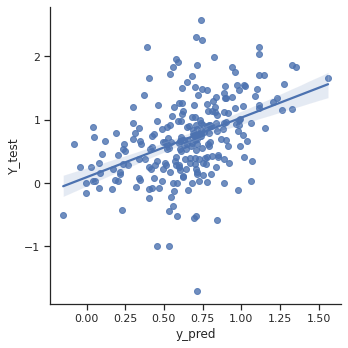

0
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
253
2-fold :  47.82608695652174
3-fold :  66.79841897233202
5-fold :  84.98023715415019
gmfe :  2.581333251465129
mfe :  1.3670662952478219
bias :  0.3217871655142277
rmse  0.548948967177769
r2  0.22876402733845347


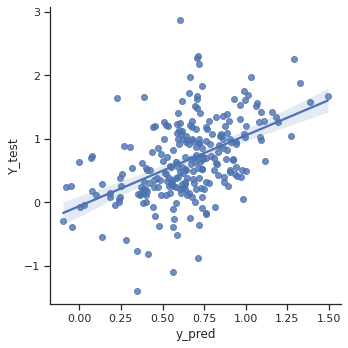

1
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
253
2-fold :  50.59288537549407
3-fold :  72.72727272727273
5-fold :  88.14229249011858
gmfe :  2.324736733931375
mfe :  1.3453602013603725
bias :  0.19456269070282595
rmse  0.4835642895108616
r2  0.2823825039724044


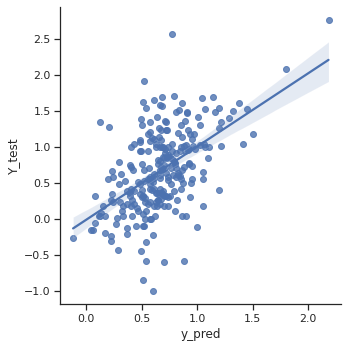

2
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
253
2-fold :  43.873517786561266
3-fold :  66.79841897233202
5-fold :  83.79446640316206
gmfe :  2.6964117320558865
mfe :  1.3953138890464698
bias :  -0.7230624810929744
rmse  0.5860968490902229
r2  0.17005327340426435


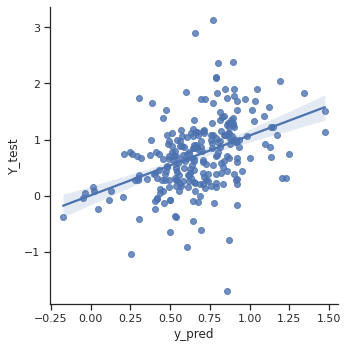

3
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
253
2-fold :  49.01185770750988
3-fold :  66.40316205533597
5-fold :  83.00395256916995
gmfe :  2.622167944074272
mfe :  1.3699443408405347
bias :  0.3784675635241459
rmse  0.5516150869610414
r2  0.2759466451044269


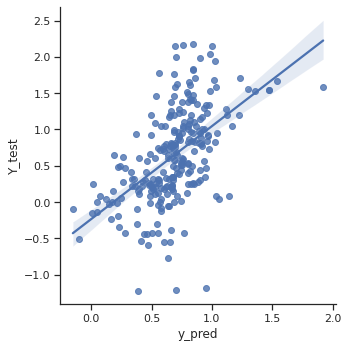

4
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
253
2-fold :  46.6403162055336
3-fold :  66.00790513833992
5-fold :  83.79446640316206
gmfe :  2.5464364450976773
mfe :  1.3918378475528457
bias :  0.1971815063069231
rmse  0.5251054226092668
r2  0.2857632001018776


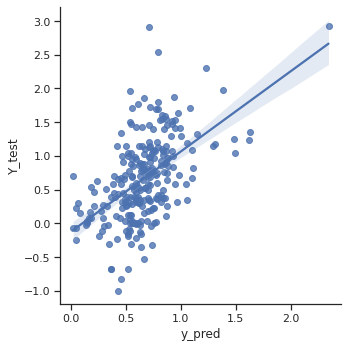

0
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  44.26877470355731
3-fold :  64.42687747035573
5-fold :  81.81818181818183
gmfe :  2.7302406914698762
mfe :  1.402012529398937
bias :  -0.16892923375245217
rmse  0.5753826006796362
r2  0.13092589186557835


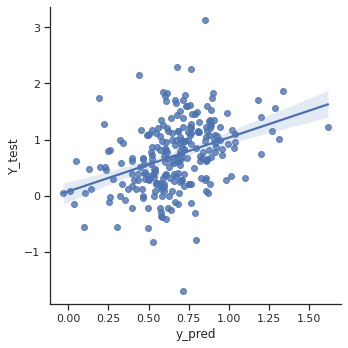

1
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=46)
253
2-fold :  49.80237154150198
3-fold :  69.56521739130434
5-fold :  84.98023715415019
gmfe :  2.4047447656050562
mfe :  1.3522466183504491
bias :  0.08469495590037646
rmse  0.4993538285553502
r2  0.22545747112073022


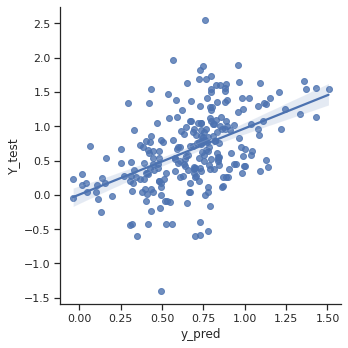

2
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=46)
253
2-fold :  50.19762845849802
3-fold :  69.96047430830039
5-fold :  84.58498023715416
gmfe :  2.4322759078122966
mfe :  1.3501682504302706
bias :  0.22956476956457417
rmse  0.5159458458384916
r2  0.2749264432063614


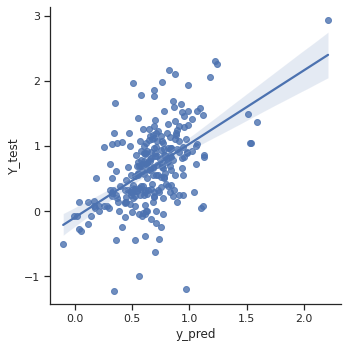

3
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=46)
253
2-fold :  43.47826086956522
3-fold :  65.21739130434783
5-fold :  84.18972332015811
gmfe :  2.7121286572891408
mfe :  1.433241179479361
bias :  0.22682027442342267
rmse  0.5732203738371996
r2  0.2927807120774236


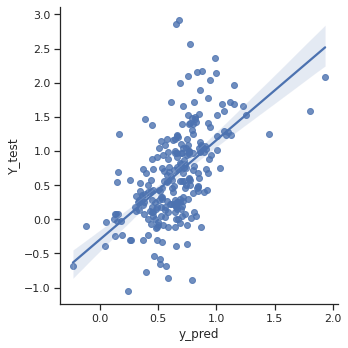

4
(1012, 152)
(253, 152)
Running ____________________human_thalf MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
253
2-fold :  49.80237154150198
3-fold :  70.35573122529645
5-fold :  83.399209486166
gmfe :  2.5301951019002185
mfe :  1.3555470472505946
bias :  0.296849911301027
rmse  0.5453587729426009
r2  0.2640445119880852


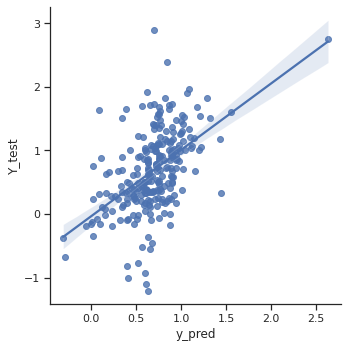

In [16]:
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    #log human_VDss_L_kg model
    data = human_lombardo_mfp
    features = features_mfp_columns
    baseline=10

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]

    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            
            print(split)
            train = df.iloc[train_index]
            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            test = df.iloc[test_index]
            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            'n_jobs': [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            
            row=[endpoint, i, split, classifier.n_estimators, classifier.max_features,
                classifier.min_samples_split, classifier.max_depth, classifier.bootstrap]
            model_parameters_batch.append(row)
            
            
            classifier.fit(X_train, Y_train)

            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_mfp_model.sav", 'wb'))

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])

In [17]:
model_parameters= pd.DataFrame(model_parameters_batch,columns=["endpoint", "random_state", 
                                                            "split", "n_estimators", "max_features",
                "min_samples_split", "max_depth", "bootstrap"])
model_parameters

endpoint  random_state  split  n_estimators max_features  \
0    human_VDss_L_kg            42      0           200         sqrt   
1    human_VDss_L_kg            42      1           200         sqrt   
2    human_VDss_L_kg            42      2           100         sqrt   
3    human_VDss_L_kg            42      3           200         sqrt   
4    human_VDss_L_kg            42      4           200         sqrt   
..               ...           ...    ...           ...          ...   
120      human_thalf            46      0           300         log2   
121      human_thalf            46      1           100         log2   
122      human_thalf            46      2           200         log2   
123      human_thalf            46      3           300         log2   
124      human_thalf            46      4           200         sqrt   

     min_samples_split  max_depth  bootstrap  
0                    8         15      False  
1                    2         15      False  
2                    4         15      False  
3                    4         15      False  
4                    2         15      False  
..                 ...        ...        ...  
120                  2         15      False  
121                  2         15      False  
122                  2         15      False  
123                  2         15      False  
124                  2         15      False  

[125 rows x 8 columns]

In [18]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                            "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

endpoint  random_state  split  \
0      human_VDss_L_kg            42      0   
1      human_VDss_L_kg            42      0   
2      human_VDss_L_kg            42      0   
3      human_VDss_L_kg            42      0   
4      human_VDss_L_kg            42      0   
...                ...           ...    ...   
29580      human_thalf            46      4   
29581      human_thalf            46      4   
29582      human_thalf            46      4   
29583      human_thalf            46      4   
29584      human_thalf            46      4   

                                                smiles_r      pred      true  \
0      C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...  0.266935  0.633468   
1      C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)... -0.171745 -0.154902   
2      C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=... -0.674448 -0.619789   
3                         C=CCc1ccccc1OCC(O)C[NH2+]C(C)C  0.201025  0.505150   
4      C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c...  0.192789  0.442480   
...                                                  ...       ...       ...   
29580  [NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...  0.764457  0.397940   
29581                 [NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21  0.683755  1.064458   
29582                [O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1  0.871569 -0.173925   
29583  [O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...  0.877594  0.000000   
29584                c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1  0.737737  0.359835   

                                                     key  
0      human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...  
1      human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...  
2      human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...  
3       human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420  
4      human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...  
...                                                  ...  
29580  human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...  
29581   human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464  
29582  human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464  
29583  human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...  
29584  human_thalfc1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1464  

[29585 rows x 7 columns]

In [19]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

HeldOut         endpoint  random_state  split     fold_2     fold_3  \
0    HeldOut  human_VDss_L_kg            42      0  51.200000  69.600000   
1    HeldOut  human_VDss_L_kg            42      1  62.000000  78.000000   
2    HeldOut  human_VDss_L_kg            42      2  58.000000  72.400000   
3    HeldOut  human_VDss_L_kg            42      3  54.800000  73.200000   
4    HeldOut  human_VDss_L_kg            42      4  48.995984  70.682731   
..       ...              ...           ...    ...        ...        ...   
120  HeldOut      human_thalf            46      0  44.268775  64.426877   
121  HeldOut      human_thalf            46      1  49.802372  69.565217   
122  HeldOut      human_thalf            46      2  50.197628  69.960474   
123  HeldOut      human_thalf            46      3  43.478261  65.217391   
124  HeldOut      human_thalf            46      4  49.802372  70.355731   

        fold_5      gmfe       mfe      bias      rmse        r2  
0    86.000000  2.319309  1.337627  0.017418  0.481735  0.462139  
1    88.400000  2.126387  1.266197  0.059761  0.438771  0.484334  
2    86.000000  2.322990  1.291161 -0.036323  0.497575  0.430031  
3    87.200000  2.208534  1.308514  0.038449  0.449062  0.518491  
4    86.345382  2.404995  1.358848  0.117811  0.492263  0.371936  
..         ...       ...       ...       ...       ...       ...  
120  81.818182  2.730241  1.402013 -0.168929  0.575383  0.130926  
121  84.980237  2.404745  1.352247  0.084695  0.499354  0.225457  
122  84.584980  2.432276  1.350168  0.229565  0.515946  0.274926  
123  84.189723  2.712129  1.433241  0.226820  0.573220  0.292781  
124  83.399209  2.530195  1.355547  0.296850  0.545359  0.264045  

[125 rows x 12 columns]

In [20]:
detail_list.to_csv("detail_list_Prediction_human_from_morgan_fs.csv", index=False)

In [21]:
model_parameters.to_csv("model_parameters_Prediction_human_from_morgan_fs.csv", index=False)

In [22]:
results.to_csv("Prediction_human_from_morgan_fs.csv", index=False)

In [23]:
import pandas as pd
results= pd.read_csv("Prediction_human_from_morgan_fs.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_from_morgan.csv", index=False)
results.groupby("endpoint").mean()

random_state  split     fold_2     fold_3     fold_5  \
endpoint                                                                   
human_CL_mL_min_kg          44.0    2.0  48.524562  68.805204  84.527602   
human_VDss_L_kg             44.0    2.0  55.244466  73.579823  86.453783   
human_fup                   44.0    2.0  47.371429  62.842597  74.401688   
human_mrt                   44.0    2.0  48.607786  67.916310  82.718487   
human_thalf                 44.0    2.0  47.841897  68.063241  84.252964   

                        gmfe       mfe      bias      rmse        r2  
endpoint                                                              
human_CL_mL_min_kg  2.571362  1.364532 -0.419293  0.558504  0.254241  
human_VDss_L_kg     2.255625  1.303905  0.036668  0.469366  0.459248  
human_fup           3.388617  1.382308  0.066663  0.260947  0.408832  
human_mrt           2.596644  1.369615  0.062804  0.555713  0.243724  
human_thalf         2.551329  1.375497  0.089930  0.537804  0.251070

In [24]:
# load
loaded_rf = pickle.load(open("log_human_VDss_L_kg_mfp_model.sav", 'rb'))

In [26]:
loaded_rf

RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)